# 词向量
- 基本用法
- 文本生成
- 可视化
- 字向量

## 原理图
神经网络语言模型结构示意图：输入层、投影层、隐藏层、输出层

![](https://img-blog.csdnimg.cn/20181204083721622.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_30,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L1llbGxvd19weXRob24=,size_16,color_FFFFFF,t_70)

模型简化
![](https://img-blog.csdnimg.cn/20181204205825523.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_30,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L1llbGxvd19weXRob24=,size_16,color_FFFFFF,t_70)

## 基本用法
https://blog.csdn.net/Yellow_python/article/details/84347878

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')  # 不打印警告
from jieba import lcut
from gensim.models import Word2Vec

In [19]:
# 数据读取
with open('news.txt', encoding='utf-8') as f:
    sentences = [lcut(s) for s in f.read().strip().split('\n')]
''.join(sentences[-1])

'北京时间TIMETIME晚，赛季cba联赛继续第轮角逐，坐镇主场的北京男篮经过四节较量以战胜广厦男篮，取得连胜并报了常规赛上半程不敌对手的一箭之仇'

In [5]:
# 建模训练
model = Word2Vec(sentences, window=9)
wv = model.wv

参数 | 解释 | 默认值
-|-|-
sentences | list of lists of tokens | None
size | 词向量维数 | 100
window | 同句中当前词和预测词的最大距离 | 5
min_count | 最低词频过滤 | 5
workers | 线程数 | 3
sg | 0：CBOW；1：skip-gram | 0
hs | 1：层次softmax；0：负例采样 | 0
negative | 负例样本数 | 5
ns_exponent | The exponent used to shape the negative sampling distribution | 0.75
cbow_mean | 0：上下文词向量求和值；1：上下文词向量平均值 | 1
alpha | 初始学习率 | 0.025
min_alpha | 最小学习率 | 0.0001

In [26]:
wv.similar_by_word('身份证', topn=4)  # 某个词的相似词

[('证件', 0.919139564037323),
 ('准考证', 0.9092125296592712),
 ('原件', 0.89948970079422),
 ('书面材料', 0.889183759689331)]

In [7]:
wv.similarity('身份证', '准考证')  # 两个词的相似度

0.90921247

In [8]:
wv.get_vector('身份证').shape  # 词 --> 词向量（维度查看）

(100,)

In [23]:
wv.similar_by_vector(vec, 3)  # 某个词向量的相似词

[('身份证', 1.0), ('证件', 0.919139564037323), ('准考证', 0.9092125296592712)]

In [10]:
wv.vectors.shape  # 词向量集（词矩阵）

(67489, 100)

In [22]:
wv.index2word[:15]  # 词列表（部分展示）

['，', '的', '在', '了', '是', '和', 'TIME', '：', '也', '有', '中国', '为', '将', '与', '中']

In [11]:
wv.index2word.__len__()  # 词总数

67489

In [27]:
model.predict_output_word(['身份证', '准考证'], 5)  # 用句子来预测词

[('准考证', 0.052992545),
 ('身份证', 0.040961884),
 ('查询', 0.023644874),
 ('办理', 0.021465328),
 ('填写', 0.016910722)]

## 文本生成（写诗小程序）
https://blog.csdn.net/Yellow_python/article/details/86726619

In [1]:
from gensim.models import Word2Vec  # 词向量
from random import choice
from os.path import exists
from warnings import filterwarnings
filterwarnings('ignore')  # 不打印警告

D:\Software\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
class CONF:
    path = 'poem.txt'  # 语料路径
    window = 16  # 滑窗大小
    min_count = 60  # 过滤低频字
    size = 125  # 词向量维度
    topn = 14  # 生成诗词的开放度
    model_path = 'word2vec'  # 模型路径

In [3]:
class Model:
    def __init__(self, window, topn, model):
        self.window = window
        self.topn = topn
        self.model = model  # 词向量模型
        self.chr_dict = model.wv.index2word  # 字典
    """模型初始化"""
    @classmethod
    def initialize(cls, config):
        if exists(config.model_path):
            model = Word2Vec.load(config.model_path)  # 模型读取
        else:
            # 语料读取
            with open(config.path, encoding='utf-8') as f:
                ls_of_ls_of_c = [list(line.strip()) for line in f]
            # 模型训练和保存
            model = Word2Vec(ls_of_ls_of_c, config.size, window=config.window, min_count=config.min_count)
            model.save(config.model_path)
        return cls(config.window, config.topn, model)
    """古诗词生成"""
    def poem_generator(self, title, form):
        # list_of_tuples --> list_of_strings 并过滤标点符号
        filter = lambda lst: [t[0] for t in lst if t[0] not in ['，', '。']]
        # 标题补全
        if len(title) < 4:
            if not title:
                title += choice(self.chr_dict)
            for _ in range(4 - len(title)):
                chrs = self.model.similar_by_word(title[-1], self.topn // 2)
                chrs = filter(chrs)
                char = choice([c for c in chrs if c not in title])
                title += char
        # 文本生成
        seq = list(title)
        for i in range(form[0]):
            for _ in range(form[1]):
                chrs = self.model.predict_output_word(seq[-self.window:], max(self.topn, len(seq) + 1))
                chrs = filter(chrs)
                char = choice([c for c in chrs if c not in seq[len(title):]])
                seq.append(char)
            seq.append('，' if i % 2 == 0 else '。')
        # 返回标题+主体
        length = form[0] * (form[1] + 1)
        title = '《%s》' % ''.join(seq[:-length])
        poem = ''.join(seq[-length:])
        return title + '\n' + poem

In [4]:
form = {'五言绝句': (4, 5), '七言绝句': (4, 7), '对联': (2, 9)}
m = Model.initialize(CONF)

In [5]:
def poetize(title):
    poem = m.poem_generator(title, form['五言绝句'])
    print('\033[031m%s\033[0m' % poem)  # red
    poem = m.poem_generator(title, form['七言绝句'])
    print('\033[033m%s\033[0m' % poem)  # yellow
    poem = m.poem_generator(title, form['对联'])
    print('\033[036m%s\033[0m' % poem)  # purple

In [6]:
poetize('春')

《春催迟频》
催晓暖睡漏，曙鸡腊残焰。钟候晨烛寒，火暑冬暄温。
《春梅萸萏》
蕊樱枝折红嫩绽，叶香莲摘杏艳粉。丛芳浓蝶花梨蜂，繁蕙蒂灼妒茸槿。
《春柳袅细》
袅柔絮堤细弱丝腰纤，条杨垂绿折软蔓嫩线。


In [8]:
poetize('杀破狼')

《杀破狼擒》
狐血狼兵蕃，战军弓豺杀。戈烽戎虏旗，阵营屯矛马。
《杀破狼狐》
猛戈豺虏弓贼军，阵营狼蕃虎铁兵。鼙射马勇防猎烽，蹄戎箭鞍骑旗旆。
《杀破狼猛》
杀妖虏勇狐戈贼狼血，豺弓猛锋兵虎防铁战。


In [9]:
poetize('御剑飞仙')

《御剑飞仙》
蓬鹤凰羽霄，凤翩翔鹓鸳。凫翼翮鸾雏，矫翅巢雀鸯。
《御剑飞仙》
羽仗鸾霓鹓凤翩，翮双翔鸳飞鹤雏。鹭鹄凰翎翼翅鸯，雀鹦燕鹉鸢乌啄。
《御剑飞仙》
仗列俨旗幢旒彤鸾殿，凤龙羽翔翼彩凰旌翮。


In [13]:
poetize('欢')

《欢尊斟沽》
罍饮樽壶觞，酣宴酒醒醉。娱杯欢斟尊，卮瓮筵歌席。
《欢杯壶缸》
宴酒醒杯樽醉劝，饮娱壶欢觞卮罍。酣倾筵席觥酌斟，琴醺瑟醪尊座宾。
《欢筵宾僚》
筵洽宾樽酌宴酒娱杯，席卮酣觞斟饮醉罍劝。


In [18]:
poetize('晚年')

《晚年衰悲》
凋冉蹉早倍，跎衰病岁壮。颜憔髭鬓改，容霜筋质肌。
《晚年时曾》
忆记岁他跎蹉早，少鬓年宦壮十昔。悴憔今衰改辛髭，斑叹筋悲咨酸零。
《晚年蹉跎》
悴冉凋跎壮年华蹉憔，宦志叹弱岁辛鬓毛筋。


In [20]:
poetize('皇妃')

《皇妃娥妆》
宫女娇殿阿，娃妒母王娥。妆蛾舞眉妃，鬟娟歌艳婵。
《皇妃珠珑》
窕女玉金佩银珮，缕殿珊绣宫钿罗。珠钗裙宝绡蛾脂，妆锦绮翠织袜婵。
《皇妃娃娇》
娇侍玉妃妾钗金佩裙，银妇钿女蛾缕鬟妆娥。


In [21]:
poetize('涟漪')

《涟漪涵溶》
荡澹浩波滟，浪漾涛鳞澜。漪摇鲸舟漂，溟楫钓泊沧。
《涟漪漾涵》
浩渺澜澹泛澄蘋，浪舟扁涛楫波棹。沧钓鳞桡屿鱼船，渔鹢矶漾鲈汀岛。
《涟漪漾洄》
漾舟洄扁桡楫艇泛渔，浦沿岸钓屿汀棹浪沧。


## 可视化

In [1]:
"""创建随机数据"""
from random import choice
ls_of_ls = [['芝士', '酸奶', '蛋糕', '巧克力', '做', '吃'],
            ['文本', '数据', '挖掘', '分析', '做', '玩'],
            ['佛山', '广州', '南海', '天河', '吃', '玩']]
ls_of_words = []  # 存放分词列表（假设是jieba.lcut后得到的）的列表
for i in range(2500):
    ls = choice(ls_of_ls)
    ls_of_words.append([choice(ls) for _ in range(9, 15)])

In [2]:
"""建模训练"""
from gensim.models import Word2Vec
model = Word2Vec(ls_of_words, size=3, window=7)

D:\Software\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
"""词向量聚类（基于密度）"""
from sklearn.cluster import DBSCAN
vectors = [model[word] for word in model.wv.index2word]
labels = DBSCAN(eps=0.24, min_samples=3).fit(vectors).labels_

D:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


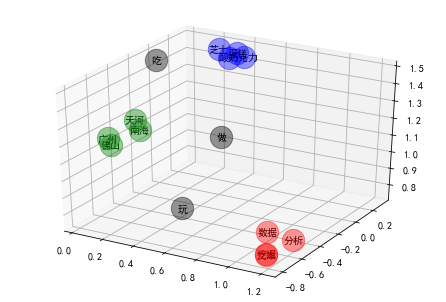

In [8]:
"""词向量可视化"""
%matplotlib inline
import matplotlib
from mpl_toolkits import mplot3d
import matplotlib.pyplot as mp
mp.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
matplotlib.rcParams['axes.unicode_minus'] = False  # 显示负号
fig = mp.figure()
ax = mplot3d.Axes3D(fig)  # 创建3d坐标轴
colors = ['red', 'blue', 'green', 'black']
for word, vector, label in zip(model.wv.index2word, vectors, labels):
    ax.scatter(vector[0], vector[1], vector[2], c=colors[label], s=500, alpha=0.4)
    ax.text(vector[0], vector[1], vector[2], word, ha='center', va='center')
mp.show()

## 词矩阵可视化
词向量可解释性：`低`

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')  # 不打印警告
%matplotlib inline
from gensim.models import Word2Vec
from seaborn import heatmap
from matplotlib import pyplot as mp
from time import time

In [2]:
n, m = 10, 1000
sentences = [
    ''.join(chr(i) for i in range(40, 50)) * n,
    ''.join(chr(i) for i in range(50, 60)) * n,
    ''.join(chr(i) for i in range(60, 70)) * n,
    ''.join(chr(i) for i in range(70, 80)) * n,
    ''.join(chr(i) for i in range(80, 90)) * n,
] * n * m

In [3]:
def matrix(sg, hs):
    t = time()
    model = Word2Vec(sentences, size=5, window=15, sg=sg, hs=hs, sorted_vocab=0, cbow_mean=0)
    print(time() - t)
    vectors = model.wv.vectors
    heatmap(vectors, center=vectors.max())
    mp.show()

28.57163429260254


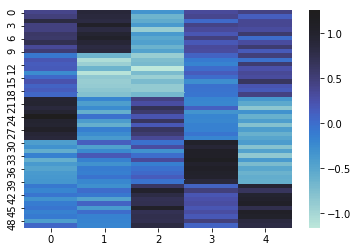

In [4]:
matrix(0, 0)  # CBOW + negative sampling

41.85939431190491


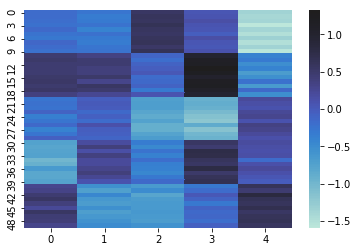

In [5]:
matrix(0, 1)  # CBOW + hierarchical softmax

108.22319006919861


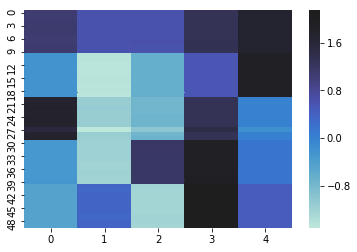

In [6]:
matrix(1, 0)  # skip-gram + negative sampling

227.66502165794373


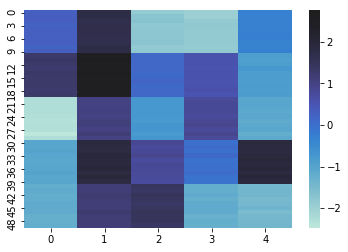

In [7]:
matrix(1, 1)  # skip-gram + hierarchical softmax

## 字向量

In [10]:
from warnings import filterwarnings
filterwarnings('ignore')  # 不打印警告
from jieba import lcut
from gensim.models import Word2Vec
import numpy as np

In [5]:
def chr2vec(word2vec=False):
    with open('news.txt', encoding='utf-8') as f:
        sentences = f.read().strip().split('\n')
        if word2vec:
            sentences = [lcut(s) for s in sentences]
    return Word2Vec(sentences, window=10, min_count=2)

In [4]:
w2v = chr2vec(word2vec=True)  # 词向量
c2v = chr2vec()  # 字向量

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 6.630 seconds.
Prefix dict has been built succesfully.


### 探究字向量和词向量嘅关系：
`冇乜卵关系`

In [6]:
get_vector = lambda model, word: model.wv.word_vec(word)
cosine_similarity = lambda vec1, vec2: vec1 @ vec2 / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [8]:
# 字向量和词向量关系函数
def relationship(word):
    v1 = get_vector(w2v, word)
    v2 = np.sum([get_vector(c2v, c) for c in word], axis=0)
    print('余弦相似度（字向量相加）', cosine_similarity(v1, v2))
    v2 = np.mean([get_vector(c2v, c) for c in word], axis=0)
    print('余弦相似度（字向量平均）', cosine_similarity(v1, v2))
    print('相近词', w2v.similar_by_word(word, topn=2))
    print('相近字')
    for char in word:
        print(c2v.similar_by_word(char, topn=2))

In [11]:
relationship('网络')

余弦相似度（字向量相加） -0.12177007
余弦相似度（字向量平均） -0.12177007
相近词 [('社交', 0.7450387477874756), ('网站', 0.7172790765762329)]
相近字
[('朋', 0.6749637722969055), ('谊', 0.5542399883270264)]
[('站', 0.7652797698974609), ('友', 0.755022406578064)]


In [12]:
relationship('朋友')

余弦相似度（字向量相加） 0.13334815
余弦相似度（字向量平均） 0.13334815
相近词 [('同事', 0.7295631170272827), ('家人', 0.6985358595848083)]
相近字
[('谊', 0.7704646587371826), ('网', 0.6749637126922607)]
[('络', 0.7550224661827087), ('站', 0.597547173500061)]


In [13]:
relationship('飞行员')

余弦相似度（字向量相加） -0.15604818
余弦相似度（字向量平均） -0.15604822
相近词 [('飞行', 0.8083478212356567), ('飞机', 0.7219115495681763)]
相近字
[('械', 0.5537397861480713), ('驶', 0.5382157564163208)]
[('促', 0.7393168807029724), ('步', 0.6123121380805969)]
[('绎', 0.41976726055145264), ('士', 0.381136953830719)]


### 文本生成（现代文）
效果：`差`

In [34]:
def text_generate(text, model, length=25, freedom=10):
    from random import choice
    seq = lcut(text)
    len_origin = len(seq)
    for i in range(length):
        chrs = model.predict_output_word(seq, max(freedom, len(seq)+1))
        char = choice([i[0] for i in chrs if i[0] not in seq[len_origin:]])
        seq.append(char)
    return ''.join(seq[len_origin:])

def generate_compare(text):
    try:
        print('\033[035m词向量模型\033[0m', text_generate(text, w2v), sep='\n')
        print('\033[035m字向量模型\033[0m', text_generate(text, c2v), sep='\n')
    except Exception as e:
        print(e)

In [18]:
generate_compare('找女朋友')

词向量模型
帮忙来吃饭去餐厅打电话找哪儿送家里钱房子回家上班打工喝出门出差老人吃陪儿子外出喝酒哥哥
字向量模型
他寻找们起踪到回想我来忆追悅麼羸婺颚看跟砾跄獾蛳捋


In [35]:
generate_compare('范冰冰')

词向量模型
身穿高圆圆身着唐嫣西装刘亦菲倪妮印花刘诗晏裙甜美高跟鞋外套皮草长裙蕾丝大衣粉色风衣性感白色黑色围巾镂空
'NoneType' object is not iterable


In [36]:
generate_compare('学业水平考试')

词向量模型
成绩文化课初试历年考研考试大纲申论真题试题复习科目试卷备考专业课测试国考考点选择题统考答题托福听力考查题型
'NoneType' object is not iterable
